# A blue book for Bulldozers

![ ](bulldozer.jpg " ")

## Overview

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration. The data is sourced from auction result postings and includes information on usage and equipment configurations.

## Data

For this competition, we are predicting the sale price of bulldozers sold at auctions.

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have. The descriptions all start with "machine configuration" in the data dictionary. Some product types do not have a particular option, so all the records for that option variable will be null for that product type. Also, some sources do not provide good option and/or hours data.

The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).


# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import re
import os
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt
import pickle
import operator
import skmisc
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from IPython.display import display
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *

In [3]:
DATA_DIR = "data/"
!ls {DATA_DIR}

appendix.frt  df_merge_2.frt  dropped_cols.frt	    merge_raw.frt  Train.csv
df_final.csv  df_merge_3.csv  keep_cols		    models	   Train.frt
df_keep.csv   df_merge.frt    Machine_Appendix.csv  tmp


# Load data

In [4]:
#%time df_train_raw = pd.read_csv(f"{DATA_DIR}Train.csv", low_memory=False, parse_dates=["saledate"])
#%time df_appendix_raw = pd.read_csv(f"{DATA_DIR}Machine_Appendix.csv", low_memory=False)

CPU times: user 1min 3s, sys: 149 ms, total: 1min 3s
Wall time: 1min 3s
CPU times: user 659 ms, sys: 56 ms, total: 715 ms
Wall time: 714 ms


In [5]:
#df_train_raw.to_feather(f"{DATA_DIR}Train.frt")
#df_appendix_raw.to_feather(f"{DATA_DIR}appendix.frt")

In [6]:
%time df_train_raw = pd.read_feather(f"{DATA_DIR}Train.frt")
%time df_appendix_raw = pd.read_feather(f"{DATA_DIR}appendix.frt")

CPU times: user 190 ms, sys: 1.01 s, total: 1.2 s
Wall time: 1.22 s
CPU times: user 52.1 ms, sys: 732 ms, total: 784 ms
Wall time: 783 ms


We merge the two dataframes by the MachineID key

In [7]:
#df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")
print(df_train_raw.columns)
print(df_appendix_raw.columns)

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')
Index(['MachineID', 'ModelID', 'fiModelDesc', 'fiBaseM

Merge the two dataframes on the key MachineID, we'll deal later with the duplicate columns fiModelDesc, ...

In [8]:
df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")

In [9]:
df_merge_raw.to_feather(f"{DATA_DIR}merge_raw.frt")

In [10]:
df_merge_raw = pd.read_feather(f"{DATA_DIR}merge_raw.frt")

Save memory by deleting the two originals dataframes

In [11]:
del df_train_raw
del df_appendix_raw

In [12]:
df_merge_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID_x', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc_x', 'fiBaseModel_x', 'fiSecondaryDesc_x',
       'fiModelSeries_x', 'fiModelDescriptor_x', 'ProductSize',
       'fiProductClassDesc_x', 'state', 'ProductGroup_x', 'ProductGroupDesc_x',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'ModelID_y', 'fiModelDesc_y', 'fiBaseModel_y', 'fiSe

Now let deal with the duplicate columns.
From the files descriptions we can deduce that the values in the appendix file are more accurate.
But first let have a look at the missing values of each duplicate columns, and verify that we can safely drop columns from the train dataframe

In [13]:
duplicate_columns = ["fiModelDesc", "fiBaseModel", "fiSecondaryDesc", "fiModelSeries",
                     "fiModelDescriptor", "fiProductClassDesc", "ProductGroup", "ProductGroupDesc", "ModelID"]
temp = {col_name: df_merge_raw[col_name+"_x"].isnull().sum() == df_merge_raw[col_name+"_y"].isnull().sum() for col_name in duplicate_columns}
temp

{'ModelID': True,
 'ProductGroup': True,
 'ProductGroupDesc': True,
 'fiBaseModel': True,
 'fiModelDesc': True,
 'fiModelDescriptor': False,
 'fiModelSeries': False,
 'fiProductClassDesc': True,
 'fiSecondaryDesc': False}

In [14]:
ok_columns = [key for key, val in temp.items() if val == True]
{col_name: [df_merge_raw[col_name+"_x"].isnull().sum(), df_merge_raw[col_name+"_y"].isnull().sum()] for col_name in duplicate_columns}

{'ModelID': [0, 0],
 'ProductGroup': [0, 0],
 'ProductGroupDesc': [0, 0],
 'fiBaseModel': [0, 0],
 'fiModelDesc': [0, 0],
 'fiModelDescriptor': [329206, 326906],
 'fiModelSeries': [344217, 343515],
 'fiProductClassDesc': [0, 0],
 'fiSecondaryDesc': [137191, 135593]}

Some "duplicate columns" does not have the same numbers of missing values, but there are less missing values in columns from the appendix file.
Hence we can drop safely the columns that originate from the train file.

In [15]:
df_merge = df_merge_raw.drop([col_name+"_x" for col_name in duplicate_columns], axis=1)

For convinience we remove the _y of each duplicate columns.

In [16]:
for col_name in duplicate_columns:
    df_merge[col_name] = df_merge[col_name+"_y"]
    df_merge.drop(col_name+"_y", axis=1, inplace=True)

In [17]:
# Let save the dataframe
df_merge.to_feather(f"{DATA_DIR}df_merge.frt")

In [18]:
del df_merge_raw

## Missing values and features engineering

In [19]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge.frt")

In [20]:
def missing_values_stats(df, keep_zeros=False):
    """
        The function return stats on the missing values in the dataframe.
        
        === Inputs ===
        df: dataframe to analyze
        keep_zeros: boolean to specify if the columns with zeros missing values are kept in the stats.
        
        === Outputs ===
        res: A data frame containing for each columns of df the total of missing values and the percetage.
        
    """
    res = pd.DataFrame()
    res["Total"] = df.isnull().sum().sort_values(ascending=False)
    res["Percentage"] = np.round((res["Total"]/len(df))*100, 2)
    if not keep_zeros:
        res = res.loc[res.Total > 0, ["Total", "Percentage"]]
    return res

In [21]:
missing_values_stats(df_merge)

,Total,Percentage
Pushblock,375906,93.71
Tip_Control,375906,93.71
Engine_Horsepower,375906,93.71
Blade_Extension,375906,93.71
Blade_Width,375906,93.71
Enclosure_Type,375906,93.71
Scarifier,375895,93.71
Hydraulics_Flow,357763,89.19
Grouser_Tracks,357763,89.19
Coupler_System,357667,89.17


### Years
From description MfgYear should be the correct version of YearMade. Let compare them to check if we can drop YearMade safely.

In [22]:
(df_merge["YearMade"] != df_merge["MfgYear"]).sum()

33864

The two columns have 33864 different entries.
Before dropping YearMade, let see if some weird values from MfgYear can be correct using YearMade.

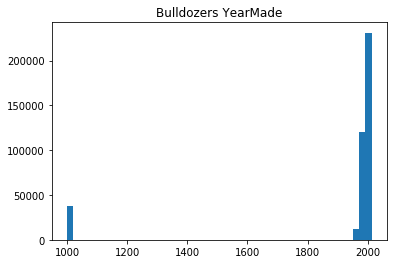

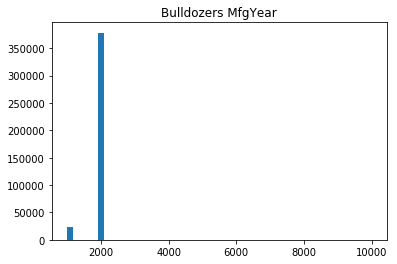

In [23]:
plt.hist(df_merge["YearMade"], bins=50)
plt.title("Bulldozers YearMade")
plt.show()
plt.hist(df_merge["MfgYear"].dropna(), bins=50)
plt.title("Bulldozers MfgYear")
plt.show()

Clearly their are some weird values: 
 - In MfgYear there are some values in the 10000's, we should replace them with the values in YearMade
 - In both features there are some bulldozers build in the 1000's which is obviously wrong, let see if there are the same in each columns

In [24]:
df_merge[df_merge.MfgYear > 2012]

,SalesID,SalePrice,MachineID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,ProductSize,...,PrimaryUpper,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,ProductGroup,ProductGroupDesc,ModelID
168998,1579170,20500,884218,132,22.0,1996,NaN,None,2009-11-21,Compact,...,1000000.0,848G,848,G,None,None,"Skidder, Wheel - 161.0 + Horsepower",SKID,Skidders,4839


In [25]:
df_merge.loc[df_merge.MfgYear > 2012, "MfgYear"] = 1996

Only one incorrect value in MfgYear greater than 2012, we replaced it by the YearMade value.

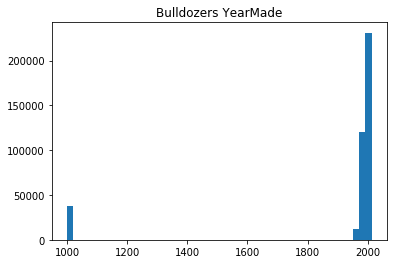

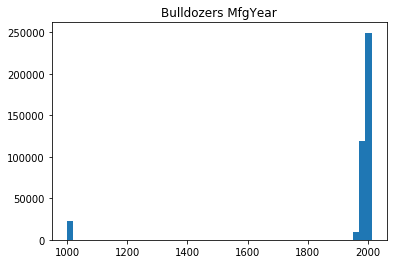

In [26]:
plt.hist(df_merge["YearMade"], bins=50)
plt.title("Bulldozers YearMade")
plt.show()
plt.hist(df_merge["MfgYear"].dropna(), bins=50)
plt.title("Bulldozers MfgYear")
plt.show()

In [27]:
print("YearMade < 1900: ", len(df_merge[df_merge.YearMade < 1900]))
print("MfgYear < 1900: ", len(df_merge[df_merge.MfgYear < 1900]))

YearMade < 1900:  38185
MfgYear < 1900:  22554


We learn from the above graphs that there are more values lesser than 1900 in YearMade than MfgYear.
We need to check if the the values in MfgYear are contains in YearMade.

In [28]:
MfgYear_idx = df_merge[df_merge.MfgYear < 1900].index
YearMade_idx = df_merge[df_merge.YearMade < 1900].index
[e for e in MfgYear_idx if e not in YearMade_idx]

[]

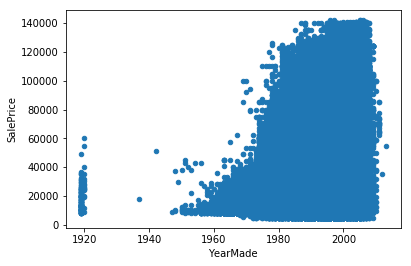

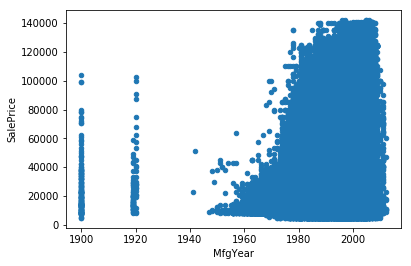

In [29]:
df_merge[df_merge.YearMade >= 1900].plot("YearMade", "SalePrice", "scatter")
plt.show()
df_merge[df_merge.MfgYear >= 1900].plot("MfgYear", "SalePrice", "scatter")

From the above graphs we can see that there others irregularities in the values of YearMade and MfgYear.
Futhermore, there is a line of values dated at 1900 in MfgYear that not appers in YearMade.
We'll replace the values of the 1900 line in MfgYear by the values in YearMade.

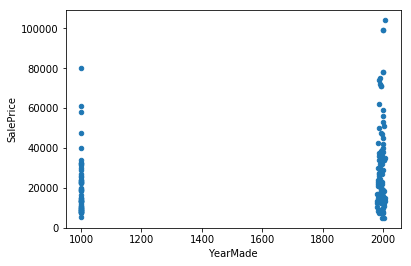

In [30]:
df_merge.iloc[df_merge[df_merge.MfgYear == 1900].index].plot("YearMade", "SalePrice", "scatter")

In [31]:
df_merge["MfgYear_correct"] = df_merge["MfgYear"]

In [32]:
df_merge.loc[df_merge.MfgYear == 1900, "MfgYear_correct"] = df_merge[df_merge.MfgYear == 1900]["YearMade"]

In [33]:
print("values <= 1920:", len(df_merge[df_merge.MfgYear_correct <=1920]), "  ", np.round(len(df_merge[df_merge.MfgYear_correct <=1920])/len(df_merge), 3), "%")

values <= 1920: 22695    0.057 %


Now to deal with the 1920's line, there is to much incorrect values to manually correct them. They represents less than 0.06% of the dataset, we can drop them without risk.

In [34]:
dropped_columns = pd.DataFrame()
dropped_columns["YearMade"] = df_merge["YearMade"]
dropped_columns["MfgYear"] = df_merge["MfgYear"]

In [35]:
df_merge.drop(["YearMade", "MfgYear"], axis=1, inplace=True)

In [36]:
df_merge.drop(df_merge[df_merge.MfgYear_correct <= 1920].index, axis=0, inplace=True)

In [37]:
df_merge["MfgYear_correct"] = df_merge["MfgYear_correct"].dropna()

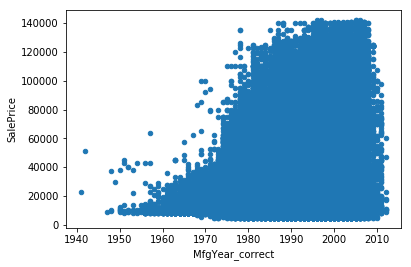

In [38]:
df_merge.plot("MfgYear_correct", "SalePrice", "scatter")

Finally we have a correct range of values for the manufacturing date. 

In [39]:
# reset index
df_merge = df_merge.reset_index(drop=True)

In [40]:
df_merge.to_feather(f"{DATA_DIR}df_merge_2.frt")
dropped_columns.to_feather(f"{DATA_DIR}dropped_cols.frt")

In [41]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge_2.frt")

### Dealing with dates

In [42]:
def date_infos(df_in, col_name, drop=True, inplace=False):
    """
    Extract infos (Year, Month, Day, Dayofweek,...) from a column containning dates. 
    
    === Inputs ===
    df_in: input dataframe.
    col_name: name of the column containning dates.
    drop: boolean that indicate if the column col_name has to be dropped.
    inplace: boolean that indicate if the transformation is done inplace.
    
    === Outputs ===
    A data frame.
    """
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    # Convert the date column to right dtype if needed
    if not np.issubdtype(df[col_name].dtype, np.datetime64):
        df[col_name] = pd.to_datetime(df[col_name], infer_datetime_format=True)
    new_idx_prefix = re.sub('[Dd]ate$', '', col_name)
    for c in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
              'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[new_idx_prefix+"_"+c] = getattr(df[col_name].dt, c.lower())
    df[new_idx_prefix+'_Elapsed'] = df[col_name].astype(np.int64) // 10**9
    if drop:
        df.drop(col_name, axis=1, inplace=True)
    return df

In [43]:
# Extract all infos from the columns date
df_merge = date_infos(df_merge, "saledate")

In [44]:
df_merge.head()

,SalesID,SalePrice,MachineID,datasource,auctioneerID,MachineHoursCurrentMeter,UsageBand,ProductSize,state,Drive_System,...,sale_Day,sale_Dayofweek,sale_Dayofyear,sale_Is_month_end,sale_Is_month_start,sale_Is_quarter_end,sale_Is_quarter_start,sale_Is_year_end,sale_Is_year_start,sale_Elapsed
0,1139246,66000,999089,121,3.0,68.0,Low,None,Alabama,None,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,57000,117657,121,3.0,4640.0,Low,Medium,North Carolina,None,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,10000,434808,121,3.0,2838.0,High,None,New York,None,...,26,3,57,False,False,False,False,False,False,1077753600
3,1398858,12000,434808,132,2.0,NaN,None,None,Kentucky,None,...,23,4,114,False,False,False,False,False,False,1082678400
4,1398859,12500,434808,132,2.0,NaN,None,None,Texas,None,...,17,2,77,False,False,False,False,False,False,1079481600


One feature that is interesting is to compute the age of a machine at the day of the sale.

In [45]:
df_merge["age"] = df_merge["sale_Year"] - df_merge["MfgYear_correct"]

Let check if there is some machine with a negative age.

In [46]:
print("machine age < 0: ", len(df_merge[df_merge.age < 0]), np.round(len(df_merge[df_merge.age < 0])/len(df_merge), 5), "%")

machine age < 0:  2283 0.00603 %


There is 2283 machines with age under 0 represeting about 0.006% of the dataset. This is too much entries to manually correct them, but the number is small enought that we can safely drop them.

In [47]:
df_merge.drop(df_merge[df_merge.age < 0].index, axis=0, inplace=True)

In [48]:
df_merge = df_merge.reset_index(drop=True)

In [49]:
df_merge.to_feather(f"{DATA_DIR}df_merge_2.frt")

### Dealing with categorical features
We start by seperate into two groups the features: categorical and numerical.
Then we study briefly the categorical features, we remark that some features have a "None or Unspecified" category. So when possible we replace missing categories by it.

In [50]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge_2.frt")

In [51]:
numerical_features = [col_name for col_name in df_merge.columns if not (pd.api.types.is_object_dtype(df_merge[col_name].dtype) or pd.api.types.is_categorical_dtype(df_merge[col_name].dtype))]
categorical_features = [col_name for col_name in df_merge.columns if pd.api.types.is_object_dtype(df_merge[col_name].dtype) or pd.api.types.is_categorical_dtype(df_merge[col_name].dtype)]

In [52]:
numerical_features

['SalesID',
 'SalePrice',
 'MachineID',
 'datasource',
 'auctioneerID',
 'MachineHoursCurrentMeter',
 'fiManufacturerID',
 'PrimaryLower',
 'PrimaryUpper',
 'ModelID',
 'MfgYear_correct',
 'sale_Year',
 'sale_Month',
 'sale_Week',
 'sale_Day',
 'sale_Dayofweek',
 'sale_Dayofyear',
 'sale_Is_month_end',
 'sale_Is_month_start',
 'sale_Is_quarter_end',
 'sale_Is_quarter_start',
 'sale_Is_year_end',
 'sale_Is_year_start',
 'sale_Elapsed',
 'age']

We see above that some numerical features missclassified and should be categorical.

In [53]:
sorted({feat: len(df_merge[feat].unique()) for feat in numerical_features}.items(), key=operator.itemgetter(1), reverse=True)

[('SalesID', 376147),
 ('MachineID', 318810),
 ('MachineHoursCurrentMeter', 14933),
 ('ModelID', 5300),
 ('sale_Elapsed', 3894),
 ('SalePrice', 881),
 ('sale_Dayofyear', 360),
 ('fiManufacturerID', 101),
 ('PrimaryLower', 74),
 ('PrimaryUpper', 71),
 ('MfgYear_correct', 68),
 ('age', 63),
 ('sale_Week', 53),
 ('auctioneerID', 31),
 ('sale_Day', 31),
 ('sale_Year', 23),
 ('sale_Month', 12),
 ('sale_Dayofweek', 7),
 ('datasource', 5),
 ('sale_Is_month_end', 2),
 ('sale_Is_month_start', 2),
 ('sale_Is_quarter_end', 2),
 ('sale_Is_quarter_start', 2),
 ('sale_Is_year_end', 2),
 ('sale_Is_year_start', 1)]

In [54]:
# Features with ID should be categorical
categorical_features.extend(["MachineID", "ModelID", "SalesID", "auctioneerID", "datasource", "fiManufacturerID"])

In [55]:
# Convert the supposed categorical features into categeory in the dataframe
for feat in categorical_features:
    df_merge[feat] = df_merge[feat].astype("category")

In [56]:
temp = {feat: len(df_merge[feat].unique()) for feat in df_merge.columns if pd.api.types.is_categorical(df_merge[feat])}
sorted(temp.items(), key=operator.itemgetter(1), reverse=True)

[('SalesID', 376147),
 ('MachineID', 318810),
 ('ModelID', 5300),
 ('fiModelDesc', 5069),
 ('fiBaseModel', 1971),
 ('fiSecondaryDesc', 183),
 ('fiProductClassDesc', 153),
 ('fiModelDescriptor', 152),
 ('fiModelSeries', 142),
 ('fiManufacturerID', 101),
 ('fiManufacturerDesc', 101),
 ('state', 53),
 ('ProductGroup', 37),
 ('ProductGroupDesc', 37),
 ('auctioneerID', 31),
 ('Stick_Length', 29),
 ('Undercarriage_Pad_Width', 20),
 ('Tire_Size', 18),
 ('Hydraulics', 13),
 ('Blade_Type', 11),
 ('Transmission', 9),
 ('Travel_Controls', 8),
 ('PrimarySizeBasis', 8),
 ('ProductSize', 7),
 ('Enclosure', 7),
 ('Blade_Width', 7),
 ('Steering_Controls', 6),
 ('datasource', 5),
 ('Drive_System', 5),
 ('Pad_Type', 5),
 ('Ripper', 5),
 ('Differential_Type', 5),
 ('UsageBand', 4),
 ('Ride_Control', 4),
 ('Enclosure_Type', 4),
 ('Tip_Control', 4),
 ('Coupler', 4),
 ('Hydraulics_Flow', 4),
 ('Thumb', 4),
 ('Pattern_Changer', 4),
 ('Grouser_Type', 4),
 ('Forks', 3),
 ('Stick', 3),
 ('Turbocharged', 3),
 ('

In [57]:
df_merge["Backhoe_Mounting"].unique()

[NaN, None or Unspecified, Yes]
Categories (2, object): [None or Unspecified, Yes]

In [58]:
# For each categorical features, if a "None or Unspecified" category exist we replace evry missing values by it
for col_name in df_merge.columns:
    if pd.api.types.is_categorical_dtype(df_merge[col_name]):
        if df_merge[col_name].isnull().sum() > 0 and "None or Unspecified" in df_merge[col_name].unique():
            df_merge[col_name] = df_merge[col_name].fillna("None or Unspecified")

In [59]:
# Save mapper from code to category and vice-versa for each categorical features
category_mapper = {col_name: {code: idx for code, idx in enumerate(col.cat.categories)} for col_name, col in df_merge.items() if pd.api.types.is_categorical_dtype(col)}
category_inv_mapper = {col_name: {idx: code for code, idx in enumerate(col.cat.categories)} for col_name, col in df_merge.items() if pd.api.types.is_categorical_dtype(col)}

In [60]:
def numericalize(df_in, inplace=False):
    """
    Convert the categorical features of the dataframe into numerical values.
    
    === Inputs ===
    df_in: dataframe to numericalize
    inplace: boolean that indicate if the transformation is done inplace
    
    === Output ===
    a dataframe with categorical features convert into numerical features
    """
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    for col_name, col in df.items():
        if pd.api.types.is_categorical_dtype(col):
            df[col_name] = col.cat.codes + 1 # +1 because Nan have -1 code
    return df

In [61]:
numericalize(df_merge, inplace=True);

Now every categorical features have been dealt with, ie, missing values replaced and category converted in numbers.
### Dealing we numerical features

In [62]:
def fix_numerical_missing_values(df_in, inplace=False):
    """
    Replace missing values of a numerical feature by the median of the column.
    Plus, add boolean column that indicate if the value was missing.
    
    === Inputs ===
    df_in: dataframe to fix
    inplace: boolean that indicate if the transformation is done inplace.
    
    === Outputs ===
    a dataframe without missing values in the numerical features. 
    """
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    for col_name, col in df.items():
        if pd.api.types.is_numeric_dtype(col):
            if col.isnull().sum():
                df[col_name+"_na"] = col.isnull()
                df[col_name] = col.fillna(col.dropna().median())
    return df

In [63]:
df_merge = fix_numerical_missing_values(df_merge)

In [64]:
missing_values_stats(df_merge)

,Total,Percentage


Finally no more missing values in the data frame.
Before building a model, let draw a pairplot of the dataframe.

In [65]:
df_merge.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'datasource', 'auctioneerID',
       'MachineHoursCurrentMeter', 'UsageBand', 'ProductSize', 'state',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'fiManufacturerID', 'fiManufacturerDesc', 'PrimarySizeBasis',
       'PrimaryLower', 'PrimaryUpper', 'fiModelDesc', 'fiBaseModel',
       'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'fiProductClassDesc', 'ProductGroup', 'ProductGroupDesc', 'ModelID',


In [66]:
# Error with feather on windows 10
df_merge.to_csv(f"{DATA_DIR}df_merge_3.csv", index=False)

## Model baseline random forest

In [4]:
df_merge = pd.read_csv(f"{DATA_DIR}df_merge_3.csv")

In [5]:
df_merge.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'datasource', 'auctioneerID',
       'MachineHoursCurrentMeter', 'UsageBand', 'ProductSize', 'state',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'fiManufacturerID', 'fiManufacturerDesc', 'PrimarySizeBasis',
       'PrimaryLower', 'PrimaryUpper', 'fiModelDesc', 'fiBaseModel',
       'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'fiProductClassDesc', 'ProductGroup', 'ProductGroupDesc', 'ModelID',


In [6]:
sale_price = np.log(df_merge["SalePrice"])

In [70]:
dropped_cols = pd.DataFrame()
dropped_cols["SalePrice"] = df_merge["SalePrice"]

In [71]:
df_merge.drop("SalePrice", axis=1, inplace=True)

In [72]:
def split_vals(a, n):
    """
    Split the frame into two frames of size len(a)-n et n
    """
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df_merge)-n_valid
x_train, x_valid = split_vals(df_merge, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((364147, 75), (364147,), (12000, 75), (12000,))

In [73]:
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)

%time random_forest.fit(x_train, y_train)

CPU times: user 7min 22s, sys: 1.16 s, total: 7min 23s
Wall time: 46.5 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [74]:
def rmse(x, y):
    """
    Cost function for the evaluation
    """
    return math.sqrt(((x-y)**2).mean())

def get_scores(rf, x_train, y_train, x_valid, y_valid):
    """
    compute the RMSE and accuracy for the train et validation set. If the oob_score is avalaible, it's added to the frame.
    """
    score = {"RMSE train": rmse(rf.predict(x_train), y_train), "RMSE valid": rmse(rf.predict(x_valid), y_valid),
             "RF score train": rf.score(x_train, y_train), "RF score valid": rf.score(x_valid, y_valid)}
    if hasattr(rf, "oob_score_"):
        score.update({"RF oob": rf.oob_score_})
    return score

In [75]:
scores = pd.DataFrame({"baseline": get_scores(random_forest, x_train, y_train, x_valid, y_valid)})

In [76]:
scores

,baseline
RF oob,0.908340
RF score train,0.987218
RF score valid,0.898353
RMSE train,0.077820
RMSE valid,0.239110


This simple model will served as baseline. The RMSE for the validation is ~0.239, which place us in the 45th position out of 470 of the kaggle public leaderbord. 
Still, the model clearly overfit as the score on the training set is much better than the validation set.
Hence, we'll look at the features importances to reduce the overfit et improve the model.

## Cross-validation or not
The point of this section is to look if we can use cross-validation for training.
We are looking if we can classify the dataset elements into the train class and the validation class.
For this, we trying to preding a vector fill as follow: v[i] = 1 if the i-th is in the validation and v[i] = 0 otherwise.
If we can predic the vector with high accuracy, this mean that there is some sort of underlining order such as chronological.

In this problem we know that the sales are sorted by date and we have to predict the next 2 months sales.

In [77]:
df_ext = df_merge.copy()
df_ext["is_valid"] = 1
df_ext["is_valid"].values[:n_trn] = 0
y = df_ext["is_valid"].values
df_ext.drop("is_valid", axis=1, inplace=True)

In [78]:
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(df_ext, y);
m.oob_score_

0.99673266036948316

We predict the dependant vector with an accuracy of 1. 
Hence, using cross-validation would be conter productive.

In [79]:
del df_ext
del y

## Features importances
In this section we investigate the features importance of the random forest.

In [80]:
def get_features_importance(model, df):
    return pd.DataFrame({"cols": df.columns, "imp": model.feature_importances_}).sort_values("imp", ascending=False)

In [81]:
feat_importance = get_features_importance(random_forest, df_merge)

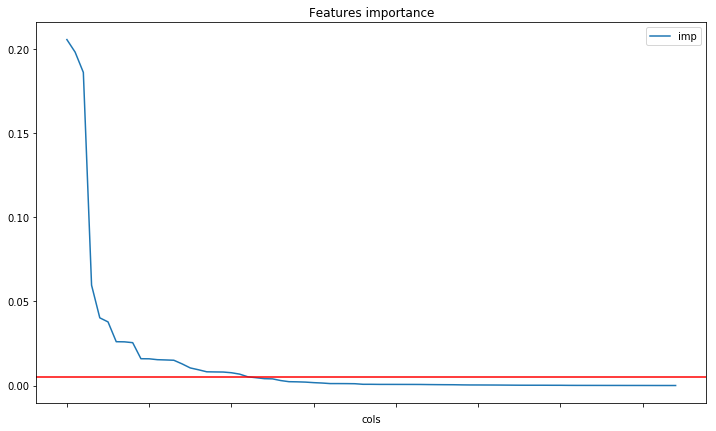

In [82]:
feat_importance.plot("cols", "imp", title="Features importance", figsize=(12,7))
plt.axhline(y=0.005, color="r")

From the above figure we can see that the features importance drop quickly and that the model use mainly 25% of the features.
We will drop features with importance less than 0.005

In [83]:
def plot_feat_importance(fi):
    fi.plot('cols', 'imp', 'barh', figsize=(12,7))

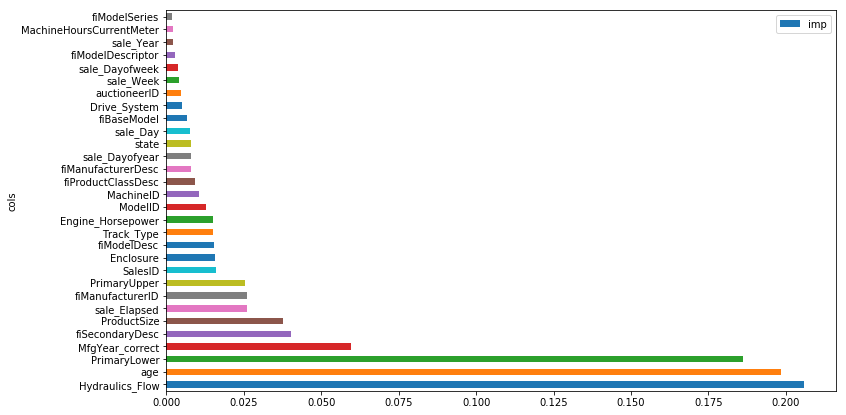

In [84]:
plot_feat_importance(feat_importance[:30])

In [85]:
feat_importance_keep = feat_importance[feat_importance.imp > .005]
len(feat_importance_keep)

23

In [86]:
with open(f"{DATA_DIR}keep_cols", "wb") as handle:
    pickle.dump(feat_importance_keep, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
df_keep = df_merge[feat_importance_keep.cols]
df_keep.head()

,Hydraulics_Flow,age,PrimaryLower,MfgYear_correct,fiSecondaryDesc,ProductSize,sale_Elapsed,fiManufacturerID,PrimaryUpper,SalesID,...,Engine_Horsepower,ModelID,MachineID,fiProductClassDesc,fiManufacturerDesc,sale_Dayofyear,state,sale_Day,fiBaseModel,Drive_System
0,2,2.0,110.0,2004.0,44,0,1163635200,8,120.0,1,...,0,652,60492,137,15,320,1,16,315,0
1,2,8.0,150.0,1996.0,61,4,1080259200,9,175.0,2,...,0,11,9294,140,16,86,33,26,568,0
2,3,3.0,1351.0,2001.0,0,0,1077753600,9,1601.0,3,...,0,1582,27886,105,16,57,32,26,118,0
3,3,3.0,1351.0,2001.0,0,0,1082678400,9,1601.0,87574,...,0,1582,27886,105,16,114,17,23,118,0
4,3,3.0,1351.0,2001.0,0,0,1079481600,9,1601.0,87575,...,0,1582,27886,105,16,77,44,17,118,0


In [88]:
raw_train, raw_valid = split_vals(df_keep, n_trn)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((364147, 23), (364147,), (12000, 23))

In [89]:
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
%time random_forest.fit(x_train, y_train)

CPU times: user 4min 7s, sys: 359 ms, total: 4min 8s
Wall time: 26 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [90]:
#scores.drop("feat_importance", axis=1, inplace=True)
scores = scores.join(pd.DataFrame({"feat_importance": get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

In [91]:
scores

,baseline,feat_importance
RF oob,0.908340,0.906025
RF score train,0.987218,0.986892
RF score valid,0.898353,0.898396
RMSE train,0.077820,0.078806
RMSE valid,0.239110,0.239060


### Redundant features
In this section we are looking at redundant features, ie, features that are correlate to each other.
If there is some correlations, we only keep one of them.

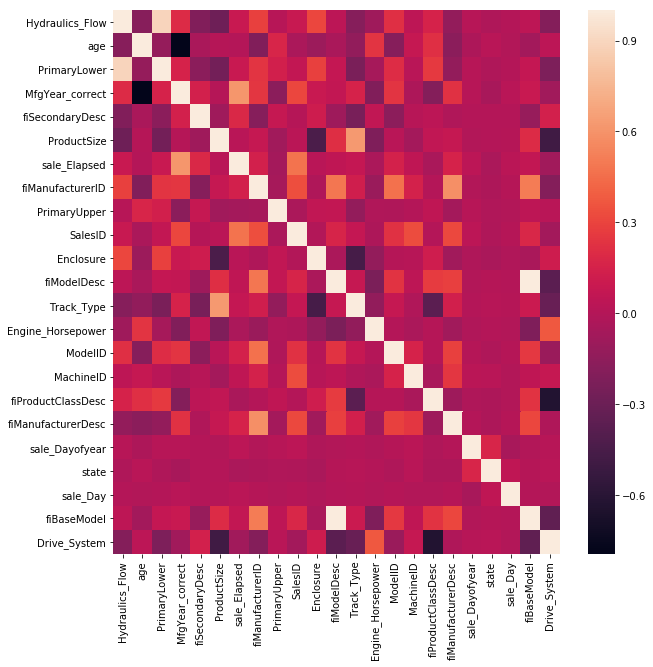

In [92]:
corr=df_keep.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

The correlation matrix is not easy looking, let plot a dendrogram.

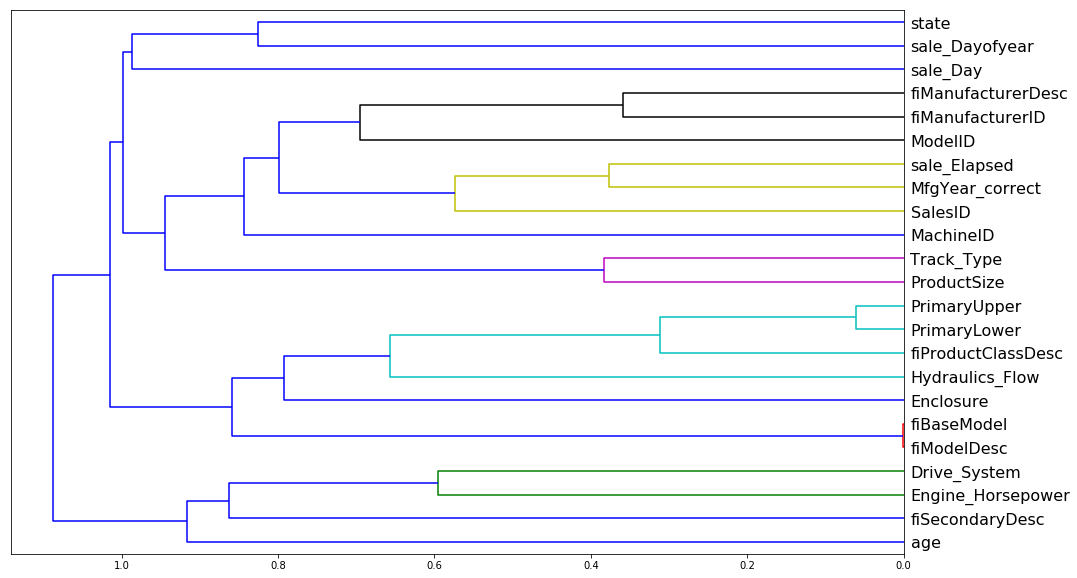

In [93]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

The dendrogram show that there is only one group of correlated features, fiBaseModel and fiModelDesc.
We are going to remove each of them one at the time and look how it's affect the oob score.
We'll remove the feature that has the less impact on the score.

In [94]:
def get_oob(df, y_train, n_trn):
    rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    rf.fit(x, y_train)
    return rf.oob_score_

In [95]:
get_oob(df_keep, y_train, n_trn)

0.90624066713789708

In [96]:
for col_name in ["fiBaseModel", "fiModelDesc"]:
    print(col_name+": ", get_oob(df_keep.drop(col_name, axis=1), y_train, n_trn))

fiBaseModel:  0.906134843527
fiModelDesc:  0.905901335134


In [97]:
dropped_columns = dropped_columns.join(df_keep["fiBaseModel"])

In [98]:
df_keep = df_keep.drop("fiBaseModel", axis=1)

In [99]:
raw_train, raw_valid = split_vals(df_keep, n_trn)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((364147, 22), (364147,), (12000, 22))

In [100]:
%time random_forest.fit(x_train, y_train)

CPU times: user 3min 57s, sys: 287 ms, total: 3min 57s
Wall time: 25.1 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [101]:
scores = scores.join(pd.DataFrame({"correlation": get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

In [102]:
scores

,baseline,feat_importance,correlation
RF oob,0.908340,0.906025,0.906091
RF score train,0.987218,0.986892,0.986899
RF score valid,0.898353,0.898396,0.897946
RMSE train,0.077820,0.078806,0.078787
RMSE valid,0.239110,0.239060,0.239588


In [103]:
df_keep.to_csv(f"{DATA_DIR}df_keep.csv", index=False)

### Partial dependance

In [104]:
df_keep = pd.read_csv(f"{DATA_DIR}df_keep.csv")

In [105]:
feat_importance = get_features_importance(random_forest, df_keep)

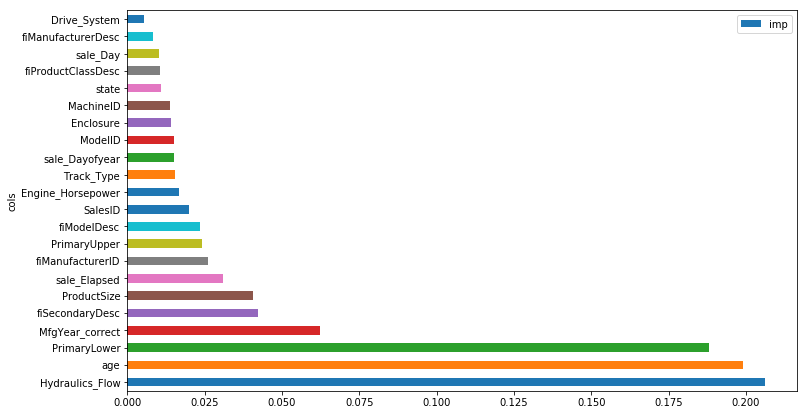

In [106]:
plot_feat_importance(feat_importance)

In [107]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [108]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(random_forest, x_train_aux, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

In [109]:
df_aux = df_keep.copy()
df_aux["SalePrice"] = sale_price
df_sample = get_sample(df_aux, 5000)

In [110]:
x_train_aux = get_sample(x_train, 1000)

{0: 'High Flow', 1: 'None or Unspecified', 2: 'Standard'}


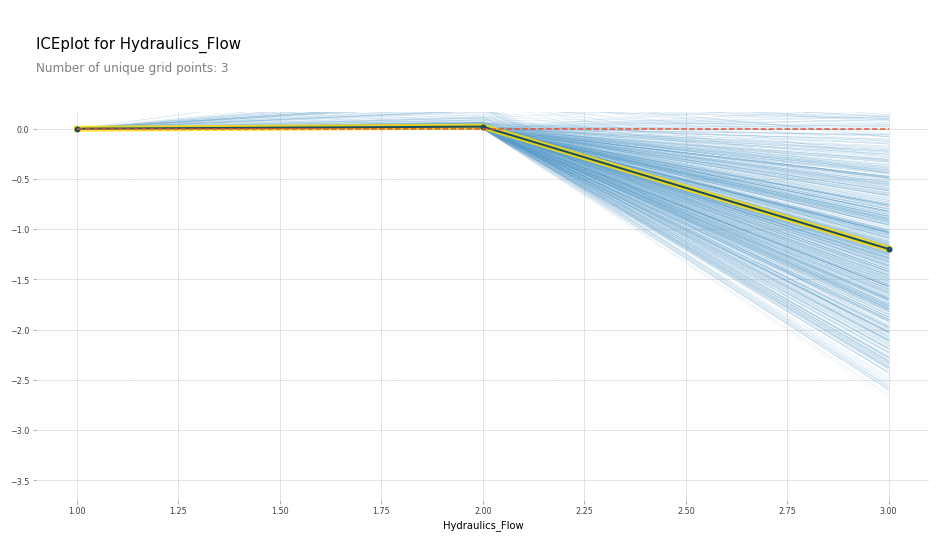

In [111]:
print(category_mapper["Hydraulics_Flow"])
plot_pdp('Hydraulics_Flow')

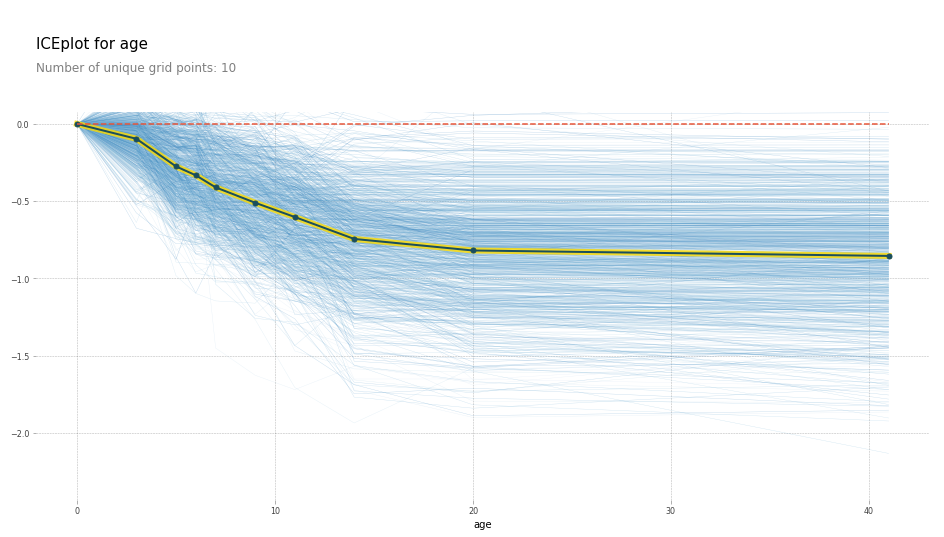

In [112]:
plot_pdp('age')

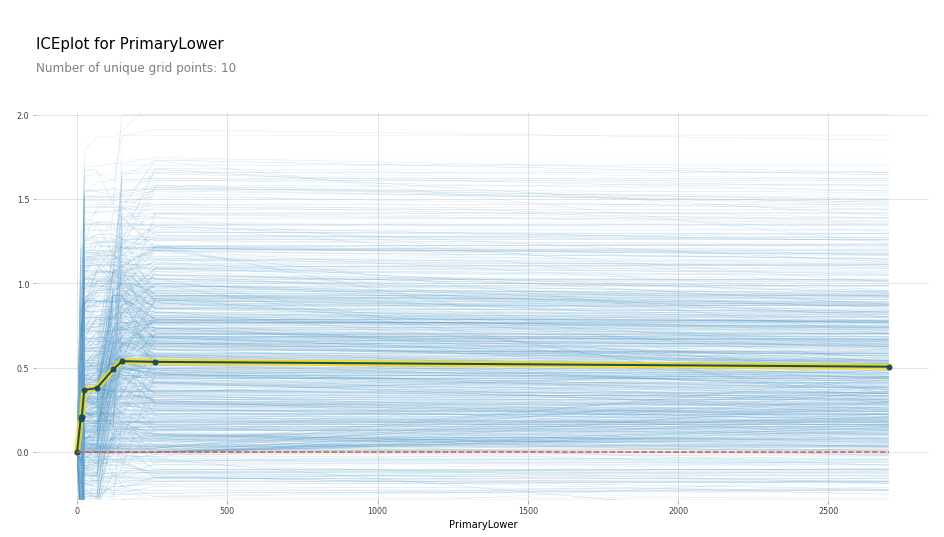

In [113]:
plot_pdp('PrimaryLower')

{'Compact': 0, 'Large': 1, 'Large / Medium': 2, 'Medium': 3, 'Mini': 4, 'Small': 5}


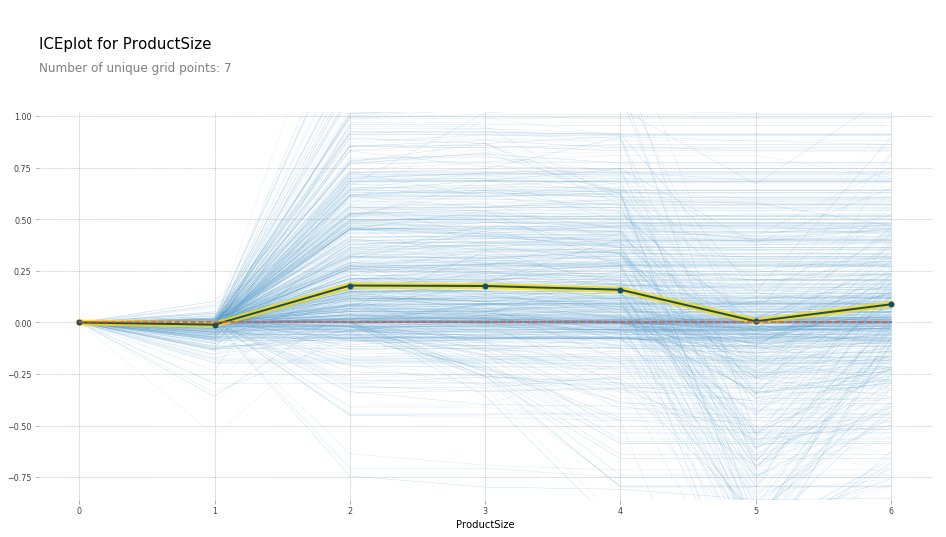

In [114]:
print(category_inv_mapper["ProductSize"])
plot_pdp("ProductSize")

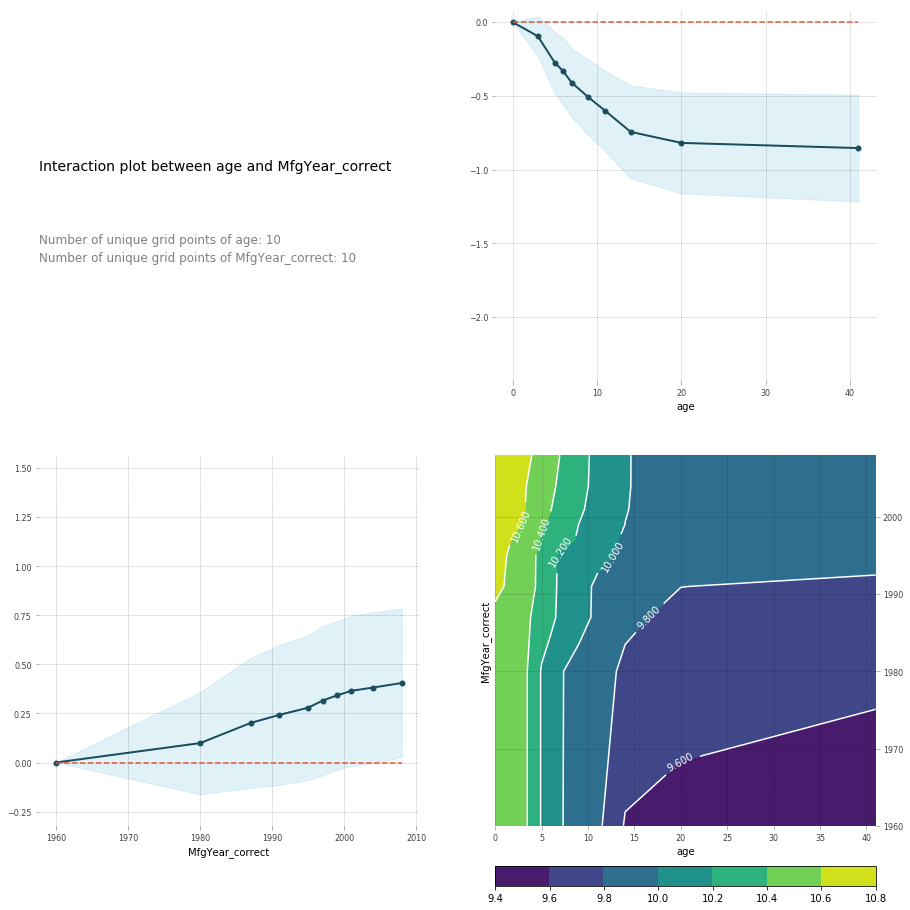

In [115]:
feats = ['age', 'MfgYear_correct']
p = pdp.pdp_interact(random_forest, x_train_aux, feats)
pdp.pdp_interact_plot(p, feats)

## Extrapolation

In [116]:
df_ext = df_keep.copy()
df_ext["is_valid"] = 1
df_ext["is_valid"].values[:n_trn] = 0
y = df_ext["is_valid"].values
df_ext.drop("is_valid", axis=1, inplace=True)

In [117]:
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(df_ext, y);
m.oob_score_

0.99682836763286697

In [118]:
df_keep.columns

Index(['Hydraulics_Flow', 'age', 'PrimaryLower', 'MfgYear_correct',
       'fiSecondaryDesc', 'ProductSize', 'sale_Elapsed', 'fiManufacturerID',
       'PrimaryUpper', 'SalesID', 'Enclosure', 'fiModelDesc', 'Track_Type',
       'Engine_Horsepower', 'ModelID', 'MachineID', 'fiProductClassDesc',
       'fiManufacturerDesc', 'sale_Dayofyear', 'state', 'sale_Day',
       'Drive_System'],
      dtype='object')

In [119]:
fi = pd.DataFrame({"cols": df_ext.columns, "imp": m.feature_importances_}).sort_values("imp", ascending=False); fi[:10]

,cols,imp
9,SalesID,0.567987
6,sale_Elapsed,0.174952
15,MachineID,0.127012
7,fiManufacturerID,0.016294
18,sale_Dayofyear,0.015022
3,MfgYear_correct,0.013096
11,fiModelDesc,0.012185
1,age,0.011046
17,fiManufacturerDesc,0.010803
14,ModelID,0.010224


In [120]:
feats=['SalesID', 'sale_Elapsed', 'MachineID']

In [121]:
df_ext.drop(feats, axis=1, inplace=True)

In [122]:
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(df_ext, y)
m.oob_score_

0.97706747627922064

In [123]:
fi = pd.DataFrame({"cols": df_ext.columns, "imp": m.feature_importances_}).sort_values("imp", ascending=False); fi[:10]

,cols,imp
15,sale_Dayofyear,0.175255
1,age,0.152810
3,MfgYear_correct,0.141635
17,sale_Day,0.100840
16,state,0.086569
12,ModelID,0.065060
9,fiModelDesc,0.056802
6,fiManufacturerID,0.032345
2,PrimaryLower,0.028743
13,fiProductClassDesc,0.028726


In [124]:
feats=['SalesID', 'sale_Elapsed', 'MachineID', 'age', 'sale_Dayofyear', "MfgYear_correct", "sale_Day"]

In [125]:
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)
m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [126]:
scores_extra = pd.DataFrame({"baseline": get_scores(m, x_train, y_train, x_valid, y_valid)})

In [127]:
for f in feats:
    print(f)
    df_subs = df_keep.drop(f, axis=1)
    x_train, x_valid = split_vals(df_subs, n_trn)
    y_train, y_valid = split_vals(sale_price, n_trn)
    m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    scores_extra = scores_extra.join(pd.DataFrame({f: get_scores(m, x_train, y_train, x_valid, y_valid)}))

SalesID
sale_Elapsed
MachineID
age
sale_Dayofyear
MfgYear_correct
sale_Day


In [128]:
scores_extra

,baseline,SalesID,sale_Elapsed,MachineID,age,sale_Dayofyear,MfgYear_correct,sale_Day
RF oob,0.905825,0.906069,0.901282,0.906937,0.905738,0.905310,0.904805,0.905977
RF score train,0.986912,0.986903,0.986269,0.986994,0.986838,0.986790,0.986726,0.986917
RF score valid,0.898637,0.904048,0.890441,0.898437,0.895167,0.898169,0.895095,0.897893
RMSE train,0.078746,0.078775,0.080659,0.078499,0.078969,0.079114,0.079303,0.078731
RMSE valid,0.238776,0.232315,0.248241,0.239011,0.242829,0.239325,0.242912,0.239650


In [129]:
scores_extra.loc[["RF score valid", "RMSE valid"]].transpose().sort_values("RF score valid", ascending=False)

,RF score valid,RMSE valid
SalesID,0.904048,0.232315
baseline,0.898637,0.238776
MachineID,0.898437,0.239011
sale_Dayofyear,0.898169,0.239325
sale_Day,0.897893,0.239650
age,0.895167,0.242829
MfgYear_correct,0.895095,0.242912
sale_Elapsed,0.890441,0.248241


In [131]:
df_final = df_keep.drop(["SalesID", "sale_Dayofyear", "MachineID", "sale_Day"], axis=1)

In [132]:
x_train, x_valid = split_vals(df_final, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)
m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)

CPU times: user 2min 19s, sys: 192 ms, total: 2min 20s
Wall time: 15.5 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [133]:
# scores.drop("extra", axis=1, inplace=True)
scores = scores.join(pd.DataFrame({"extra": get_scores(m, x_train, y_train, x_valid, y_valid)}))

In [134]:
scores

,baseline,feat_importance,correlation,extra
RF oob,0.908340,0.906025,0.906091,0.906734
RF score train,0.987218,0.986892,0.986899,0.985239
RF score valid,0.898353,0.898396,0.897946,0.907773
RMSE train,0.077820,0.078806,0.078787,0.083628
RMSE valid,0.239110,0.239060,0.239588,0.227760


In [135]:
m = RandomForestRegressor(n_estimators=150, n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)

CPU times: user 7min, sys: 1.15 s, total: 7min 1s
Wall time: 42.9 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [136]:
get_scores(m, x_train, y_train, x_valid, y_valid)

{'RF oob': 0.90992057815273997,
 'RF score train': 0.98594285269468107,
 'RF score valid': 0.90881946614747888,
 'RMSE train': 0.0816104938768068,
 'RMSE valid': 0.2264648701712181}

In [ ]:
df_final.to_csv(f"{DATA_DIR}df_final.csv", index=False)

In [ ]:
with open("models/final", "wb") as handle:
    pickle.dump(m, handle)

## Deep Learning

In [7]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *

In [8]:
df_final = pd.read_csv(f"{DATA_DIR}df_final.csv")

In [9]:
df_final.drop(df_final.columns[0], axis=1, inplace=True)

In [10]:
df_final.columns

Index(['Hydraulics_Flow', 'age', 'PrimaryLower', 'MfgYear_correct',
       'fiSecondaryDesc', 'ProductSize', 'sale_Elapsed', 'fiManufacturerID',
       'PrimaryUpper', 'Enclosure', 'fiModelDesc', 'Track_Type',
       'Engine_Horsepower', 'ModelID', 'fiProductClassDesc',
       'fiManufacturerDesc', 'state', 'Drive_System'],
      dtype='object')

In [11]:
# for col_name in df_final.columns:
#    df_final[col_name] = df_final[col_name].astype(float)

In [12]:
cat_feats=["Hydraulics_Flow", "PrimaryLower", "ProductSize", "fiSecondaryDesc", "fiManufacturerID",
           "PrimaryUpper", "Enclosure", "fiModelDesc", "Track_Type", "ModelID", "fiProductClassDesc",
           "fiManufacturerDesc", "state", "Drive_System", "Engine_Horsepower", "PrimaryLower"]

In [13]:
df_final_cat = df_final[cat_feats]

In [41]:
df_final.drop(cat_feats, axis=1, inplace=True)

In [42]:
df_final = df_final.join(df_final_cat)

In [44]:
df_final.columns

Index(['age', 'MfgYear_correct', 'sale_Elapsed', 'Hydraulics_Flow',
       'PrimaryLower', 'ProductSize', 'fiSecondaryDesc', 'fiManufacturerID',
       'PrimaryUpper', 'Enclosure', 'fiModelDesc', 'Track_Type', 'ModelID',
       'fiProductClassDesc', 'fiManufacturerDesc', 'state', 'Drive_System',
       'Engine_Horsepower', 'PrimaryLower'],
      dtype='object')

In [14]:
emb_c = {col_name: len(df_final[col_name].unique()) for col_name in cat_feats}
emb_c

{'Drive_System': 5,
 'Enclosure': 6,
 'Engine_Horsepower': 3,
 'Hydraulics_Flow': 3,
 'ModelID': 5300,
 'PrimaryLower': 73,
 'PrimaryUpper': 70,
 'ProductSize': 7,
 'Track_Type': 3,
 'fiManufacturerDesc': 101,
 'fiManufacturerID': 101,
 'fiModelDesc': 5069,
 'fiProductClassDesc': 153,
 'fiSecondaryDesc': 183,
 'state': 53}

In [23]:
y = sale_price
n_trn = 12000
val_idx = list(range(n_trn, len(df_final)))
val_idx = [n_trn]

In [36]:
val_idx = [i for i in range(len(df_final))]

for i in range(0, len(df_final) - n_trn):
    val_idx[i] = 0

In [37]:
md = ColumnarModelData.from_data_frame(DATA_DIR, val_idx, df_final, y, cat_flds=cat_feats, bs=12)

In [ ]:
md.

In [17]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [18]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]
metrics=[rmse]

In [19]:
emb_szs

[(3, 2),
 (73, 37),
 (7, 4),
 (183, 50),
 (101, 50),
 (70, 35),
 (6, 3),
 (5069, 50),
 (3, 2),
 (5300, 50),
 (153, 50),
 (101, 50),
 (53, 27),
 (5, 3),
 (3, 2)]

In [20]:
y_range=(0,np.max(y)*1.2)

In [21]:
m = md.get_learner(emb_szs, len(cat_feats), 0.05, 1, [500,250], [0.5,0.05],
                   y_range=y_range, use_bn=True)

In [22]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/THCTensorCopy.cu:204